In [59]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import database as db
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import itertools
import random
import time

# Discriminator

In [60]:
class GANdiscriminator(nn.Module):
    ''' This class implements a PatchGAN discriminator for a 100x100 image.
        Small modification of the one used in:
            - Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks 
              Jun-Yan Zhu, 2017'''
    
    def __init__(self, n_image_channels = 3):
        super(GANdiscriminator, self).__init__()
                
        def createLayer(n_filt_in, n_filt_out, ker_size, stride, norm = True, last = False):
            ''' This function creates the differnt convolutional layers, all with same structure'''
            layers = [nn.Conv2d(n_filt_in, n_filt_out, ker_size, stride=stride)]
            if (norm):
                layers.append(nn.InstanceNorm2d(n_filt_out)) # batch normalization
            if (last):
                layers.append(nn.Sigmoid()) # we output the probability
            else:
                layers.append(nn.LeakyReLU(negative_slope = 0.05, inplace=True)) # we use Leaky ReLU
            return layers
        
        
        ''' Input number of filters: Image channels
            Intermediate number of filters: 64*h, with h being the depth of the layer
            Output number of filters: 1 -> Decision of true or false
            It takes patches of 61x61 pixels'''
        layers = []
        n_layers = 5
        ker_size = 5
        strides = [1, 1, 1, 2, 2]
        n_filters = [n_image_channels, 64, 128, 256, 512, 1]
        lasts = [False, False, False, False, True]
        for i in range(n_layers): # For each layer
            layers.extend(createLayer(n_filters[i], n_filters[i+1], ker_size, strides[i], last = lasts[i]))
                
        self.model = nn.Sequential(*layers)
        
    
    def forward(self, image):
        return self.model(image)

# Generator

In [61]:
class residual_block(nn.Module):
    ''' This class implements the residual block of the RES net we will implement as the generator'''
    def __init__(self, n_channels):
        super(residual_block, self).__init__()
        
        layers = [ 
                  nn.ReflectionPad2d(1), # mirroring of 1 for the 3 kernel size convolution
                  nn.Conv2d(n_channels, n_channels, 3), # the convolution :)
                  nn.InstanceNorm2d(n_channels), # batch normalization
                  nn.LeakyReLU(negative_slope=0.05, inplace=True), 
                  # We repeat the process
                  nn.ReflectionPad2d(1), 
                  nn.Conv2d(n_channels, n_channels, 3),
                  nn.InstanceNorm2d(n_channels)
                 ]
        
        self.conv_block = nn.Sequential(*layers)
    
    def forward(self, image):
        return image + self.conv_block(image)

In [62]:
class GANgenerator(nn.Module):
    ''' This class implements a RES Net for generating the images
        Small modification of the one defined in:
            - Deep Residual Learning for Image Recognition
              Kaiming He, 2015'''
    
    def __init__(self, n_image_channels = 3, n_res_blocks = 9):
        super(GANgenerator, self).__init__()
        
        ''' High kernel convolution '''
        n_channels_high = 64
        layers = [ nn.ReflectionPad2d(3), # mirroring of 3 for the 7 kernel size convolution
                    nn.Conv2d(n_image_channels, n_channels_high, 7), # 64 new channels of 7x7 convolution :)
                    nn.InstanceNorm2d(n_channels_high),
                    nn.LeakyReLU(negative_slope=0.05, inplace=True)
                  ]
        
        ''' Variables for down and up sampling '''
        n_layers = 2
        ker_size = 3
        strides = 2
        paddings = 1
        n_filters = [n_channels_high, n_channels_high*2, n_channels_high*4]
        
        ''' Downsampling steps '''
        for i in range(n_layers): # for each layer
            layers.extend([ nn.Conv2d(n_filters[i], n_filters[i+1], ker_size, \
                                    strides, padding=paddings),
                            nn.InstanceNorm2d(n_filters[i+1]),
                            nn.LeakyReLU(negative_slope=0.05, inplace=True)])
        
        ''' Residual blocks '''
        for i in range(n_res_blocks):
            layers.extend([residual_block(n_filters[-1])]) # the residual blocks are applied to the 
                                                           # last number of channels in the down sampling
        
        ''' Upsampling steps '''
        for i in range(n_layers): # for each layer
            layers.extend([ nn.ConvTranspose2d(n_filters[-(i+1)], n_filters[-(i+2)], ker_size, \
                                    strides, padding=paddings, output_padding=1),
                            nn.InstanceNorm2d(n_filters[-(i+2)]),
                            nn.LeakyReLU(negative_slope=0.05, inplace=True)])
        ''' Output '''
        layers.extend([ nn.ReflectionPad2d(3), # mirroring of 3 for the 7 kernel size convolution
                        nn.Conv2d(n_channels_high, n_image_channels, 7), # 64 new channels of 7x7 convolution :)
                        nn.Sigmoid() ])
                
        self.res_net = nn.Sequential(*layers)
        
    def forward(self, image):
        return self.res_net(image)

# Training

In [63]:
# Losses
criterion_gan = nn.BCELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [64]:
# Prepare for using cuda or not
cuda = True if torch.cuda.is_available() else False # for using the GPU if possible

In [65]:
# Calculate the number of patches (61x61) separated 25
batch_size = 1
img_x = 128
img_y = 128
separation = 25
patch_x, patch_y = 26, 26
patch = (batch_size, 1 , patch_x, patch_y)

In [66]:
# Generation of the discriminator and generator
D_A = GANdiscriminator()
D_B = GANdiscriminator()
G_AB = GANgenerator()
G_BA = GANdiscriminator()
if cuda:
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    criterion_gan.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

In [67]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal(m.weight.data, a=0.05)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.kaiming_normal(m.weight.data, a=0.05)
        torch.nn.init.constant_(m.bias.data, 0.0)

G_AB.apply(weights_init); # He initialization of the weights
G_BA.apply(weights_init); # He initialization of the weights
D_A.apply(weights_init); # He initialization of the weights
D_B.apply(weights_init); # He initialization of the weights

In [68]:
# Define the optimizer for the generator
lr = 1e-4
beta_1 = 0.9
beta_2 = 0.99
gan_params = list(G_AB.parameters()) + list(G_BA.parameters())
optimizer_G = torch.optim.Adam(gan_params, lr = lr, betas=(beta_1, beta_2))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta_1, beta_2))

In [69]:
class lr_update():
    def __init__(self, n_epochs, epoch, start_decay_epoch):
        assert ((n_epochs - start_decay_epoch) > 0), "You can't decay after finishing"
        self.n_epochs = n_epochs
        self.epoch = epoch
        self.start_decay_epoch = start_decay_epoch
    
    def decay(self, epoch):
        return 1.0 - max(0, epoch + self.epoch - self.start_decay_epoch) \
            / (self.n_epochs - self.start_decay_epoch)

In [70]:
# Scheduler for optimization
n_epochs = 250
epoch = 0
start_decay_epoch = 100

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, \
    lr_lambda=lr_update(n_epochs, epoch, start_decay_epoch).decay)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, \
    lr_lambda=lr_update(n_epochs, epoch, start_decay_epoch).decay)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, \
    lr_lambda=lr_update(n_epochs, epoch, start_decay_epoch).decay)

In [76]:
# Structure for using cuda tensors or just cpu tensors
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [77]:
# class to store the images
class imageBuffer():
    def __init__(self, max_size = 50):
        assert (max_size > 0), 'You need to be able to store something'
        self.max_size = max_size
        self.data = []
    
    def push_and_pop(self, data):
        result = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            # If we can store data
            if len(self.data) < self.max_size:
                self.data.append(element)
                result.append(element)
            # Else change a random element of the data with probability 0.5
            else:
                if random.uniform(0,1) > 0.5:
                    pos = random.randint(0, self.max_size-1)
                    result.append(self.data[pos].clone())
                    self.data[i] = element
                else:
                    result.append(element)
        # Return the result as a torch variable
        return Variable(torch.cat(result))

In [78]:
# Buffers of previously generated samples 
fake_A_buffer = imageBuffer()
fake_B_buffer = imageBuffer()

In [82]:
# Prepare the data
fruits_file = 'Dataset/dataset_index.csv'
textures_file = 'Dataset/textures_index.csv'
textures = db.TexturesDataset(csv_file=textures_file)
train_imgs_A = db.FruitsDataset(csv_file=fruits_file, cl='Strawberry', 
                        transform = transforms.Compose(
                            [db.ChangeBackground(textures),
                             db.myReshape()]))
train_imgs_B = db.FruitsDataset(csv_file=fruits_file, cl='Orange', 
                        transform = transforms.Compose(
                            [db.ChangeBackground(textures),
                             db.myReshape()]))
dataloader_A = DataLoader(train_imgs_A, batch_size=batch_size,
                        shuffle=True, num_workers=1)

dataloader_B = DataLoader(train_imgs_B, batch_size=batch_size,
                        shuffle=True, num_workers=1)
val_dataloader_A = DataLoader(train_imgs_A, batch_size=5,
                        shuffle=True, num_workers=1)
val_dataloader_B = DataLoader(train_imgs_B, batch_size=5,
                        shuffle=True, num_workers=1)

In [83]:
def sample_images(num_batches):
    ''' Saves a generated sample from the validation set'''
    img_A = next(iter(val_dataloader_A))
    img_B = next(iter(val_dataloader_B))
    real_A = Variable(img_A.type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(img_B.type(Tensor))
    fake_A = G_BA(real_B)
    ## Gudardar-les després és cosa d'en Marcel

In [86]:
# Training phase

start_time = time.time()

for epoch in range(n_epochs):
    print("##########################################################")
    print("- EPOCH: " + str(epoch))
    print("##########################################################")
    for i, batch_A in enumerate(dataloader_A):
        
        # Get Model input
        real_A = Variable(batch_A.type(Tensor))
        real_B = Variable(next(iter(dataloader_B)).type(Tensor))
        
        
        '''
        # Get model input
        input_img = Variable(batch.type(Tensor))
        
        #Generator 
        
        # Set the optimizer
        optimizer_G.zero_grad()
        
        # Create some noise
        noise = Variable(Tensor(np.random.normal(loc = 0.0, \
            scale= 0.5, size=batch.shape)))
    
        # Generate some images from the noise
        generated = G(noise)
        
        # See how well they do
        loss_g = criterion(D(generated),valid)
        
        # We use backpropagation
        loss_g.backward(retain_graph=True)
        
        # And make ADAM do its shit
        optimizer_G.step()
        
        # Discriminator 
        
        # Set the optimizer
        optimizer_D.zero_grad()
        
        loss_d_real = criterion(D(input_img),valid)
        loss_d_fake = criterion(D(generated),fake)
        loss_d = 0.5 * (loss_d_real + loss_d_fake)
        
        # We use backpropagation
        loss_d.backward(retain_graph=True)
        
        # We let ADAM do its shit
        optimizer_D.step()
        
        print("Image #: " + str(i*batch_size))
        
        '''

##########################################################
- EPOCH: 0
##########################################################


Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <

    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multipr

  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line

    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multi

    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/d

Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/pytho

    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file de

    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/

    self.index_queue.put(None)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 355, in put
    self._writer.send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f3da9f01b00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 250, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 246, in _shutdown_workers
    self.index_queue.put(None)
  File "/usr/lib/python3.5/multi

KeyboardInterrupt: 

In [37]:
 # Create some noise
noise = Tensor(np.random.normal(loc = 0.0, \
    scale= 0.9, size=batch.shape))

noise = Tensor(np.zeros(batch.shape))

# Generate some images from the noise
generated = G(noise)

In [42]:
v = generated[1].data.cpu().numpy()
v = np.transpose(v, (2,1,0))
v.shape

(128, 128, 3)

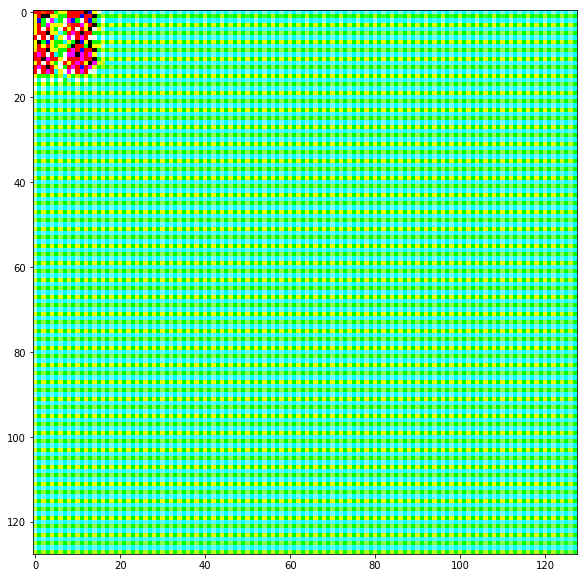

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(v)
plt.show()

In [44]:
 loss_g = criterion(D(generated),valid)

In [45]:
loss_g

Variable containing:
 0.7115
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [47]:
loss_d_real = criterion(D(input_img),valid)
loss_d_fake = criterion(D(generated),fake)
loss_d = 0.5 * (loss_d_real + loss_d_fake)

In [48]:
loss_d_real

Variable containing:
 0.7198
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [49]:
loss_d_fake

Variable containing:
 0.7140
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [50]:
loss_d

Variable containing:
 0.7169
[torch.cuda.FloatTensor of size 1 (GPU 0)]

TypeError: 'method' object is not iterable

In [ ]:

input_img = Tensor(batch_size,3,img_x,img_y)
valid = Variable(Tensor(np.ones(patch)), requires_grad=False)
fake = Variable(Tensor(np.zeros(patch)), requires_grad=False)

In [57]:
0 % 1

0